In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sb
import os
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore")
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from PIL import Image
from skimage.color import rgb2gray

# primary model

In [3]:
ds="UTKFace"
img_paths=[]
age_labels=[]
gender_labels=[]
for filename in tqdm(os.listdir(ds)):
    image_path=os.path.join(ds,filename)
    temp=filename.split("_")
    age=int(temp[0])
    gender=int(temp[1])
    imop=Image.open(image_path)
    img_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [4]:
gender_dict={0:"Male",1:"Female"}

## exploratory data analysis

Text(0.5, 1.0, '17')

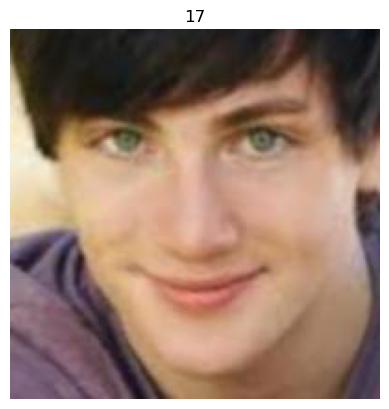

In [5]:
plt.axis("off")
plt.imshow(Image.open(img_paths[1050]));
plt.title(f"{age_labels[1050]}")

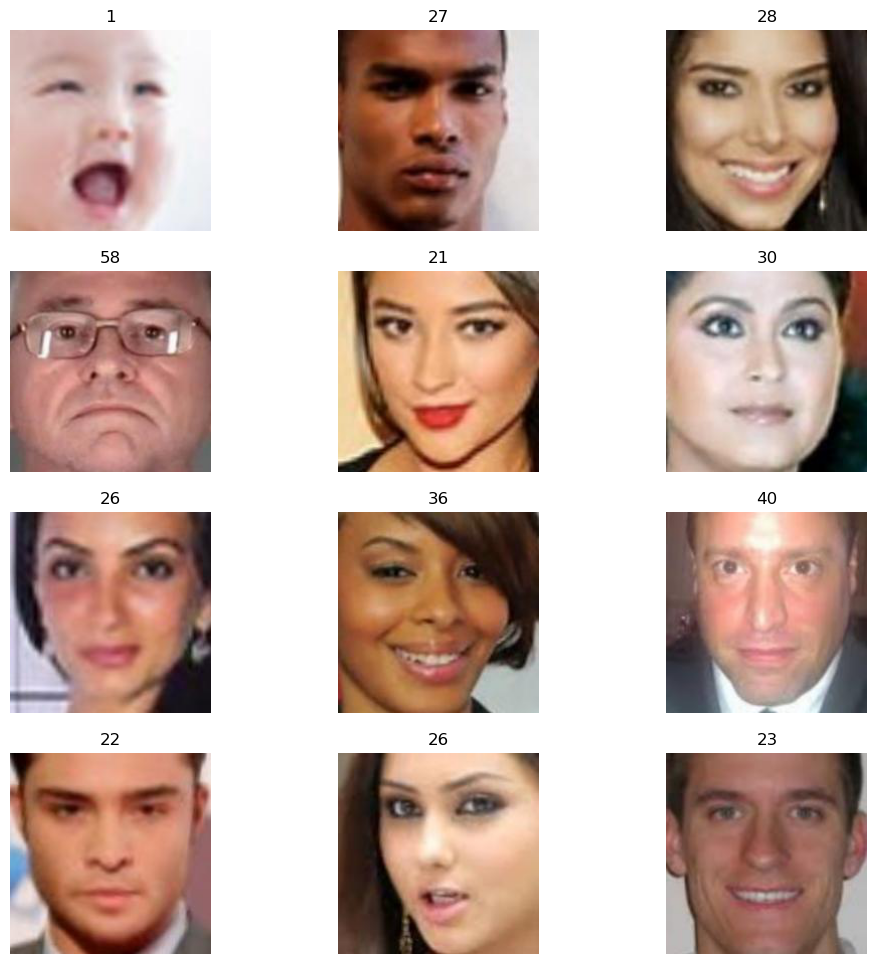

In [6]:
plt.figure(figsize=(12,12))
for i in range(1,13):
    ind=np.random.randint(23700)
    plt.subplot(4,3,i)
    plt.imshow(Image.open(img_paths[ind]));
    plt.title(age_labels[ind])
    plt.axis('off')

<Axes: ylabel='Density'>

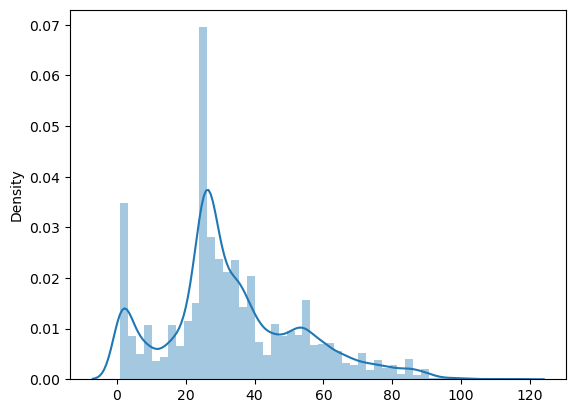

In [7]:
sb.distplot(age_labels)

<Axes: ylabel='Density'>

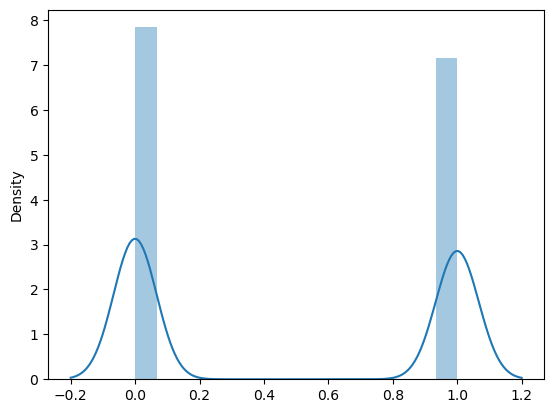

In [8]:
sb.distplot(gender_labels)

# feature extraction

# for age model

In [9]:
def extract_features(images):
    features=[]
    for image in tqdm(images):
        img = load_img(image,grayscale=True)
        img = img.resize((228,228), Image.ANTIALIAS)
        img=np.array(img)
        features.append(img)
    features=np.array(features)
    features=features.reshape(len(features),228,228,1)
    return features
gen_image=extract_features(img_paths)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [10]:
gen_image.shape

(23708, 228, 228, 1)

In [11]:
gen_image[5].shape

(228, 228, 1)

In [12]:
gen_image[7]

array([[[186],
        [188],
        [190],
        ...,
        [118],
        [111],
        [107]],

       [[181],
        [184],
        [187],
        ...,
        [118],
        [109],
        [103]],

       [[173],
        [176],
        [183],
        ...,
        [119],
        [106],
        [100]],

       ...,

       [[210],
        [209],
        [207],
        ...,
        [219],
        [219],
        [219]],

       [[210],
        [208],
        [207],
        ...,
        [219],
        [219],
        [219]],

       [[210],
        [208],
        [207],
        ...,
        [219],
        [219],
        [219]]], dtype=uint8)

In [13]:
gen_image.dtype

dtype('uint8')

In [14]:
# data normalization
gen_image=gen_image/255.0
input_shape=(228,228,1)

In [15]:
y_gender=np.array(gender_labels)

# model creation

In [16]:
inputs = Input(input_shape)
conv_1 = Conv2D(32, kernel_size=(3, 3), activation="relu")(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation="relu")(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation="relu")(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation="relu")(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten=Flatten() (maxp_4)

# fully connected layes
dense_1=Dense(256,activation="relu")(flatten)
dense_2=Dense(256,activation="relu")(flatten)

dropout_1=Dropout(0.3)(dense_1)
dropout_2=Dropout(0.3)(dense_2)

output_1=Dense(1,activation='sigmoid',name="gender_out")(dropout_1)
# output_2=Dense(1,activation='relu',name="age_out")(dropout_2)

model=Model(inputs=[inputs],outputs=output_1)

model.compile(loss=['binary_crossentropy','mae'],optimizer='adam',metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 228, 228, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 226, 226, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 128)       73856 

# taining the model for gender accuray

In [ ]:
history = model.fit(x=gen_image, y=y_gender, batch_size=64, epochs=4, validation_split=0.2)

Epoch 1/4
297/297 [==============================] - 1472s 5s/step - loss: 0.4417 - accuracy: 0.7818 - val_loss: 0.4597 - val_accuracy: 0.7815
Epoch 2/4


# Evaluation Graph

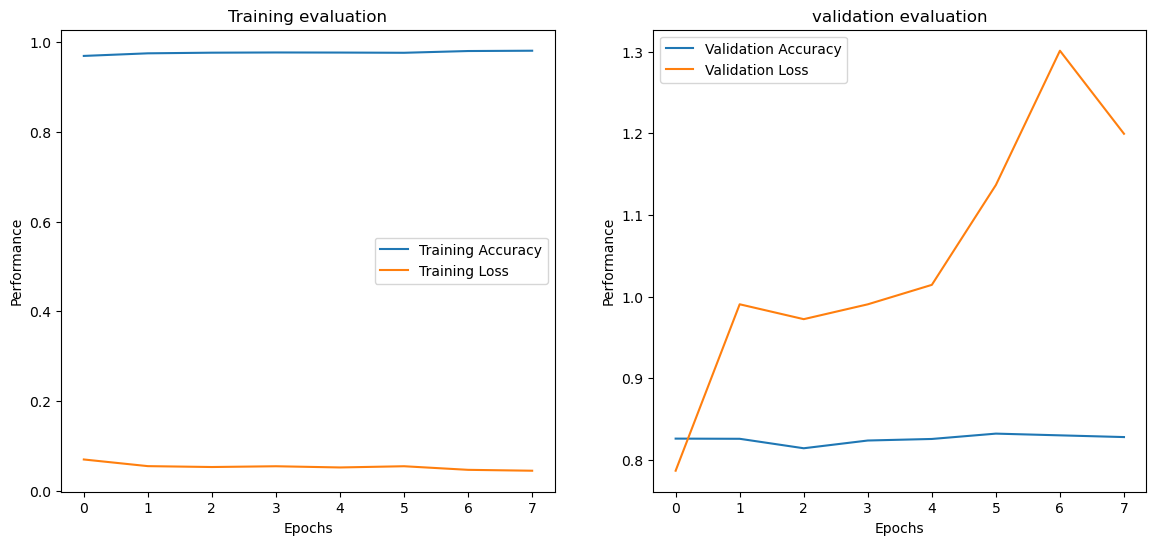

In [105]:
train_accuracy=history.history["accuracy"]
train_loss=history.history['loss']
val_loss=history.history['val_loss']
val_accuracy=history.history["val_accuracy"]
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(train_accuracy,label='Training Accuracy')
plt.plot(train_loss,label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel('Performance')
plt.title("Training evaluation")
plt.legend()
plt.subplot(1,2,2)
plt.plot(val_accuracy,label="Validation Accuracy")
plt.plot(val_loss,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel("Performance")
plt.title("validation evaluation")
plt.legend()

In [15]:
model.save("gender_recognition_model.h5")

# training for age accuracy

In [73]:
from tensorflow.keras import layers
agemodel = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='linear')
])
agemodel.compile(optimizer='adam', loss='mean_squared_error')

graph=agemodel.fit(x,y_age, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
593/593 [==============================] - 469s 770ms/step - loss: 147.6362 - val_loss: 1076.8906
Epoch 2/10
593/593 [==============================] - 430s 725ms/step - loss: 90.5353 - val_loss: 709.7581
Epoch 3/10
593/593 [==============================] - 389s 657ms/step - loss: 74.6853 - val_loss: 768.7985
Epoch 4/10
593/593 [==============================] - 392s 661ms/step - loss: 65.1337 - val_loss: 508.9907
Epoch 5/10
593/593 [==============================] - 403s 680ms/step - loss: 58.1565 - val_loss: 485.2692
Epoch 6/10
593/593 [==============================] - 385s 649ms/step - loss: 51.9875 - val_loss: 550.0260
Epoch 7/10
593/593 [==============================] - 385s 650ms/step - loss: 47.0798 - val_loss: 593.9211
Epoch 8/10
593/593 [==============================] - 443s 748ms/step - loss: 42.6230 - val_loss: 562.8994
Epoch 9/10
593/593 [==============================] - 411s 693ms/step - loss: 39.0416 - val_loss: 308.8613
Epoch 10/10
593/593 [==============

In [74]:
agemodel.save("age_recognition_model.h5")

In [76]:
loss= agemodel.evaluate(x,y_age)

741/741 [==============================] - 170s 220ms/step - loss: 105.4191


## plot acuracy

In [12]:
# plot for gender
acc=history.history["gender_out_accuracy"]
val_acc=history.history["val_gender_out_accuracy"]
epochs=range(len(acc))
plt.plot(epochs,acc,"b",label="Training Accuracy")
plt.plot(epochs,val_acc,"r",label="Validation Accuracy")
plt.title("Accuracy Graph")
plt.legend()
plt.figure()

loss=history.history["gender_out_loss"]
val_loss=history.history["val_gender_out_loss"]
plt.plot(epochs,loss,"b",label="Training Loss")
plt.plot(epochs,val_loss,"r",label="Validation Loss")
plt.title("Loss Graph")
plt.legend()
plt.show()

In [13]:
# plot for age
acc=history.history["age_out_accuracy"]
val_acc=history.history["val_age_out_accuracy"]
epochs=range(len(acc))
plt.plot(epochs,acc,"b",label="Training accuracy")
plt.plot(epochs,val_acc,"r",label="Validation accuracy")
plt.title("Accuracy Graph")
plt.legend()
plt.show()

## Testing the predictions

In [9]:
from tensorflow.keras.models import load_model
model=load_model("gender_recognition_model.h5")
agemodel=load_model("age_recognition_model.h5")
gender_dict={0:"Male",1:"Female"}

Original Gender: Female 
Original Age: 25
1/1 [==============================] - 1s 623ms/step
Predicted Gender: Female 
Predicted Age: 28


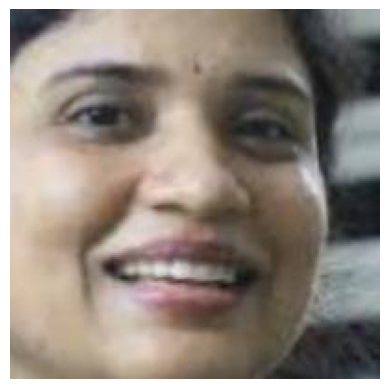

In [10]:
ind=5674
ip=df["image"][ind]
image = Image.open(ip)
print("Original Gender:",gender_dict[df["gender"][ind]],"\nOriginal Age:",df["age"][ind])
b=image.resize((128,128))
grayscale_image = b.convert("L")
input_image = np.array(grayscale_image).reshape(1, 128, 128, 1) / 255.0
pred=model.predict(input_image)
pred_gender=gender_dict[round(pred[0][0][0])]
# pred_age=round(pred[1][0][0])
print("Predicted Gender:",pred_gender,"\nPredicted Age:",round(agemodel.predict(input_image)[0][0]))
plt.axis("off")
plt.imshow(np.array(grayscale_image), cmap="gray");
plt.imshow(image);

In [11]:
og,oa,pg,pa = [],[],[],[]
for img_index in range(100, 112):
    og.append(gender_dict[y_gender[img_index]])
    oa.append(y_age[img_index])
    pred = model.predict(x[img_index].reshape(1, 128, 128, 1))
    pg.append(gender_dict[round(pred[0][0][0])])
    pa.append(round(agemodel.predict(x[img_index].reshape(1, 128, 128, 1))[0][0]))
predf = pd.DataFrame({
    "predicted gender": pg,
    "predicted age": pa,
    "original gender": og,
    "original age": oa})
predf

1/1 [==============================] - 0s 281ms/step


,predicted gender,predicted age,original gender,original age
0,Female,726,Male,10
1,Male,1198,Male,10
2,Male,399,Male,10
3,Male,1540,Male,10
4,Male,842,Male,10
5,Male,1031,Male,10
6,Male,818,Male,10
7,Male,775,Male,10
8,Male,610,Male,10
9,Male,377,Male,10


# predicting image other than dataset

1/1 [==============================] - 0s 54ms/step
Predicted Gender: Male 
Predicted Age: 10


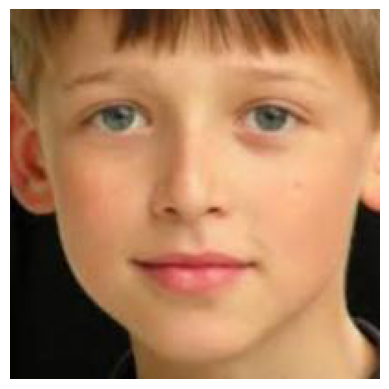

In [7]:
# individual image prediction
image = Image.open("dataface/ab.jpg")
b=image.resize((128,128))
grayscale_image = b.convert("L")
input_image = np.array(grayscale_image).reshape(1, 128, 128, 1) / 255.0
print("Predicted Gender:",gender_dict[round(model.predict(input_image)[0][0][0])],"\nPredicted Age:",round(agemodel.predict(input_image)[0][0]))
plt.axis("off")
plt.imshow(np.array(grayscale_image), cmap="gray");
plt.imshow(image);

In [148]:
data=[]
image_folder = "faces"  # Replace with the folder containing your images
for image_file in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path)
    b=image.resize((128,128))
    grayscale_image = b.convert("L")
    input_image = np.array(grayscale_image).reshape(1, 128, 128, 1) / 255.0
    pred=model.predict(input_image)
    pred_gender=gender_dict[round(pred[0][0][0])]
    pred_age=round(pred[1][0][0])
    data.append([image_path, pred_gender, pred_age])
df1 = pd.DataFrame(data, columns=['Input_Image', 'Output_Gender', 'Output_Age'])
df1

1/1 [==============================] - 0s 51ms/step


,Input_Image,Output_Gender,Output_Age
0,faces\A.jpg,Female,28
1,faces\am.jpg,Male,32
2,faces\cris.jpg,Female,27
3,faces\d.jpg,Male,34
4,faces\mihir.jpg,Male,46
5,faces\nilesh.jpg,Male,29
6,faces\priya.jpg,Female,37
7,faces\R.jpg,Male,37
8,faces\r2.jpg,Male,29
9,faces\raj.jpg,Male,8
